In [17]:
!pip install Roboflow
from PIL.Image import core as _imaging
from cv2 import imshow
from sklearn import svm
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
import numpy as np
import cv2
from roboflow import Roboflow
import os
from google.colab.patches import cv2_imshow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
def Dkl(p,q):
    p+=1
    q+=1
    return p*np.log(p/q)

def compareToMaxRGBToDelta(Mc,N):
    Re = np.zeros_like(Mc[:,:,0])
    A1 = Dkl(Mc[:,:,0],N[:,:,0])
    A2 = Dkl(Mc[:,:,1],N[:,:,1])
    A3 = Dkl(Mc[:,:,2],N[:,:,2])
    for i in range(Mc.shape[0]):
        for j in range(Mc.shape[1]):
            Re[i,j] = max([A1[i,j],A2[i,j],A3[i,j]])
            if Re[i,j]<0 :
                Re[i,j]=0
    return Re

def chDim(img):
    dim = (40 , 40)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized


def listDataTransFeature(mX,LMc):
    L=[]
    for N in mX :
        Re = np.zeros_like(N[:,:,0])
      # compare data N to each Mc get in max RGB to obtain Nc
        Nc1 = compareToMaxRGBToDelta(LMc[0],N)
        Nc2 = compareToMaxRGBToDelta(LMc[1],N)
        Nc3 = compareToMaxRGBToDelta(LMc[2],N)
        Nc4 = compareToMaxRGBToDelta(LMc[3],N)
        # transform train data to feature X,compare Nc to Mc;  get max of 4(c) classes to 1 called X 
        for i in range(N.shape[0]):
            for j in range(N.shape[1]):
                Re[i,j] = max([Nc1[i,j],Nc2[i,j],Nc3[i,j],Nc4[i,j]])
        L.append(Re)
    return np.array(L)

def imageShow(label,index,Xtrain):
    images=[]
    image = []
    for i in range(len(Xtrain[index])):
        if i%20 == 0:
            if i==20:
                images = image    
            if i!=0 and i!=20:
                images = np.vstack((images, image))
            image=Xtrain[index][i]
        else :
            image = np.hstack((image, Xtrain[index][i]))
    cv2_imshow(images)


In [10]:
# get data and split to train data , there are 4 classes Font, Back, Left, Right
"""
rf = Roboflow(api_key='NumKUmse6lxWaKXtxd2i',model_format='yolov5')
datasets = rf.workspace().project('face-direction').version('1').download(location="/content/faceAngle")
"""
#rf = Roboflow(api_key="NumKUmse6lxWaKXtxd2i",model_format='yolov5')
#datasets1 = rf.workspace("head-direction-vjv1b").project("face-direction").version('4').download(location="\\content\\faceAngle")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to \content\faceAngle in yolov5pytorch:: 100%|██████████| 4492/4492 [00:06<00:00, 695.58it/s] 


In [19]:

Xtrain=[[],[],[],[]]
imgPath = '/content/faceAngle1/train/images'
posLabelPath = '/content/faceAngle1/train/labels'
imgList = os.listdir(imgPath)
posLabelList = os.listdir(posLabelPath)

for i in range(len(imgList)):
    image = cv2.imread(imgPath+"/"+imgList[i])
    img = np.asarray(image)
    f = open(posLabelPath+"/"+posLabelList[i])
    lines = f.readlines()
    for line in lines:
        posLabel = np.array([np.float(i) for i in line.strip().split()])
        startX = int(image.shape[0]*(posLabel[2]-0.5*posLabel[-1]))
        startY = int(image.shape[1]*(posLabel[1]-0.5*posLabel[-2]))
        EndX = int(image.shape[0]*(posLabel[2]+ 0.5*posLabel[-1]))
        EndY = int(image.shape[1]*(posLabel[1]+ 0.5*posLabel[-2]))
        if(len(Xtrain[int(posLabel[0])])<400):
            Xtrain[int(posLabel[0])].append(chDim(img[startX:EndX, startY:EndY,::-1]))
        
    f.close
print("Xtrain Size :", len(Xtrain[0]),len(Xtrain[1]),len(Xtrain[2]),len(Xtrain[3]))
mX = []
my = []

mX+=Xtrain[0]
mX+=Xtrain[1]
mX+=Xtrain[2]
mX+=Xtrain[3]
my+=[0 for i in range(len(Xtrain[0]))]
my+=[1 for i in range(len(Xtrain[1]))]
my+=[2 for i in range(len(Xtrain[2]))]
my+=[3 for i in range(len(Xtrain[3]))]


# get average data of each classes called Mc (all data)
Mc1 = Mc2 = Mc3= Mc4 = np.zeros_like(Xtrain[1][0])
for i in Xtrain[0]:
    Mc1+=i
for i in Xtrain[1]:
    Mc2+=i
for i in Xtrain[2]:
    Mc3+=i
for i in Xtrain[3]:
    Mc4+=i
Mc1=Mc1/len(Xtrain[0])
Mc2=Mc2/len(Xtrain[1])
Mc3=Mc3/len(Xtrain[2])
Mc4=Mc4/len(Xtrain[3])
LMc = np.array([Mc1,Mc2,Mc3,Mc4])
XFeaturesTrain = listDataTransFeature(mX,LMc)

"""
for i in range(len(Xtrain[0])):
    
    
    if i%20 == 0:
        image=Xtrain[0][i]
        if i==20:
            images = images
        if i!=0:
            images = np.vstack((images, image))
    else :
        image = np.hstack((image, Xtrain[0][i]))
"""



`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Xtrain Size : 400 400 400 400


'\nfor i in range(len(Xtrain[0])):\n    \n    \n    if i%20 == 0:\n        image=Xtrain[0][i]\n        if i==20:\n            images = images\n        if i!=0:\n            images = np.vstack((images, image))\n    else :\n        image = np.hstack((image, Xtrain[0][i]))\n'

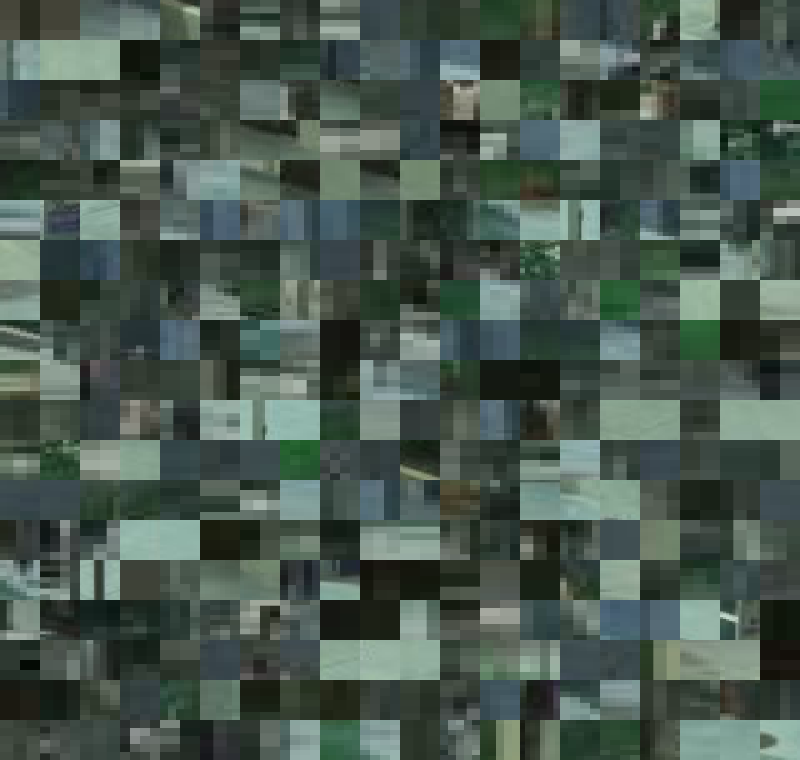

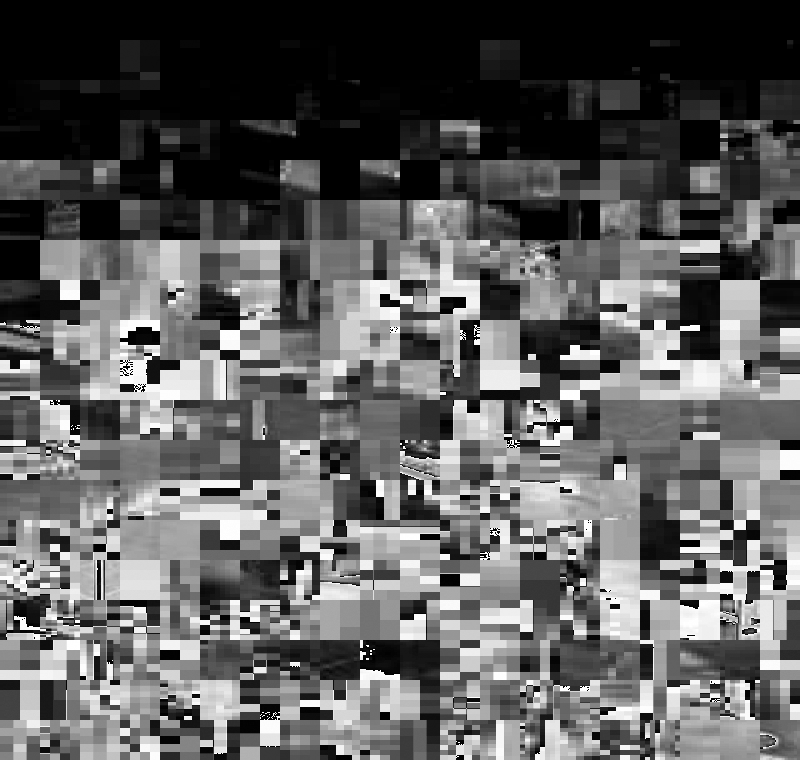

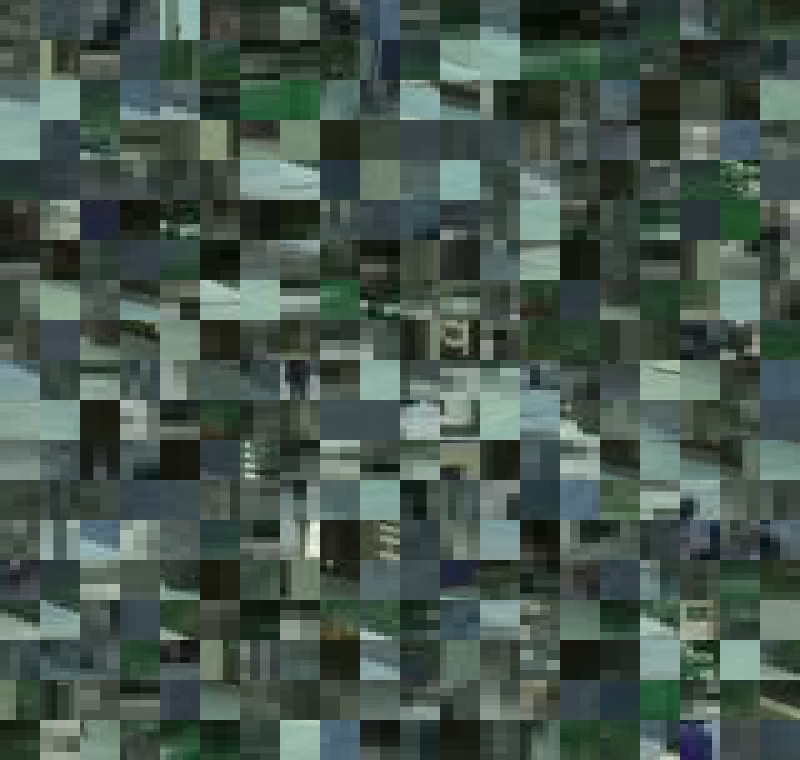

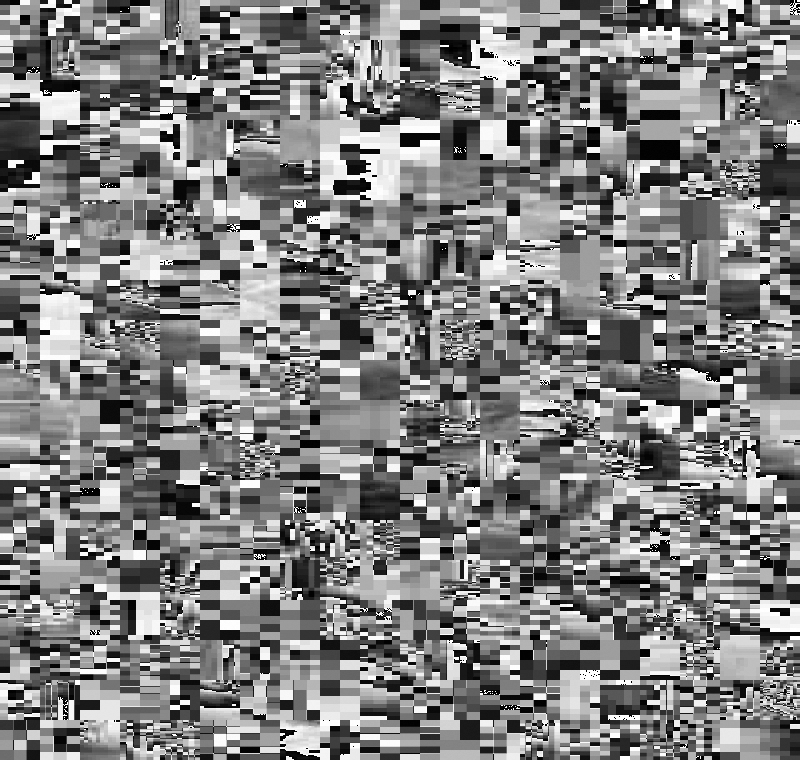

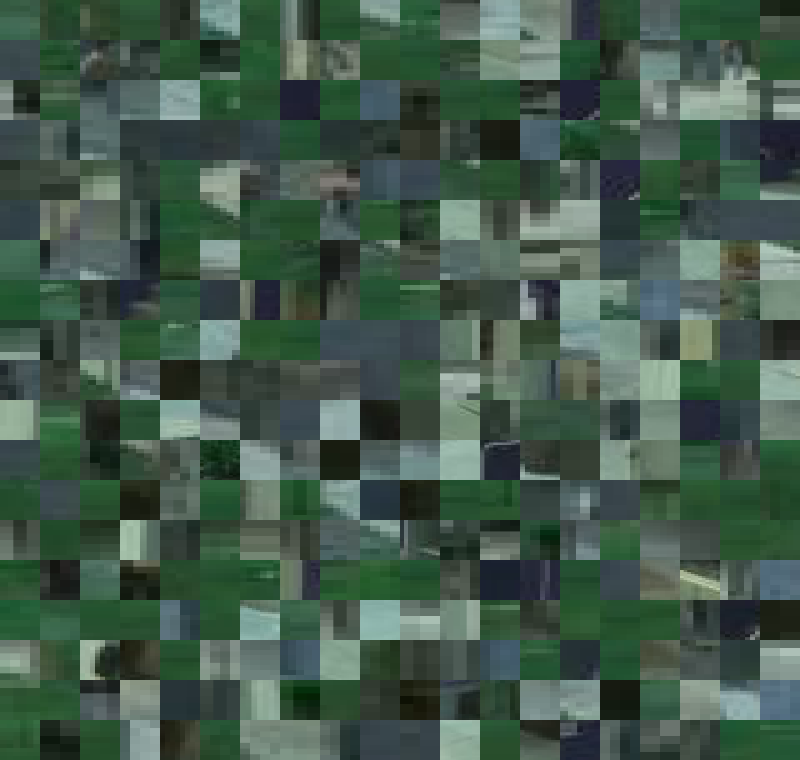

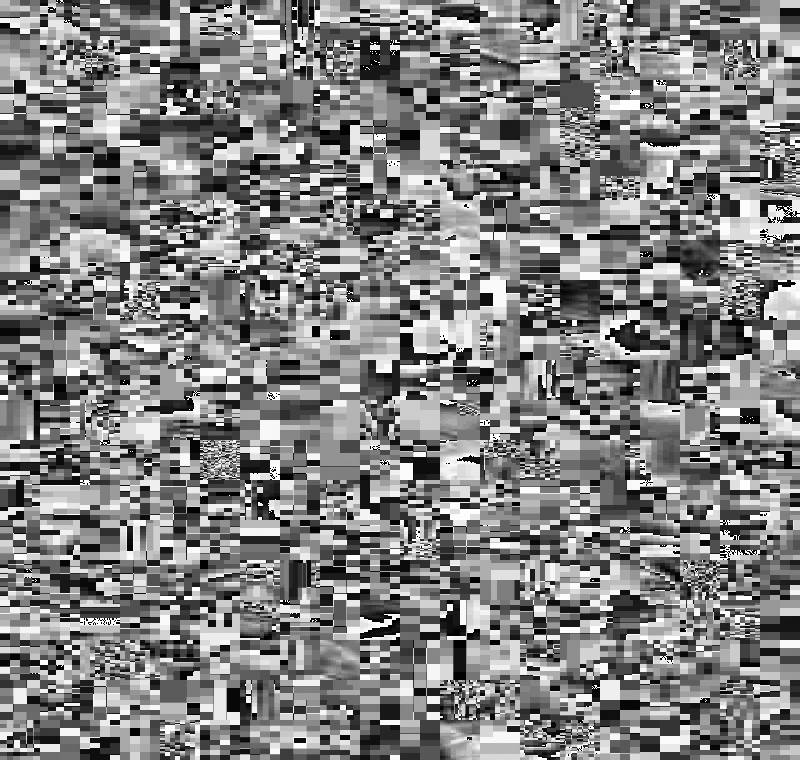

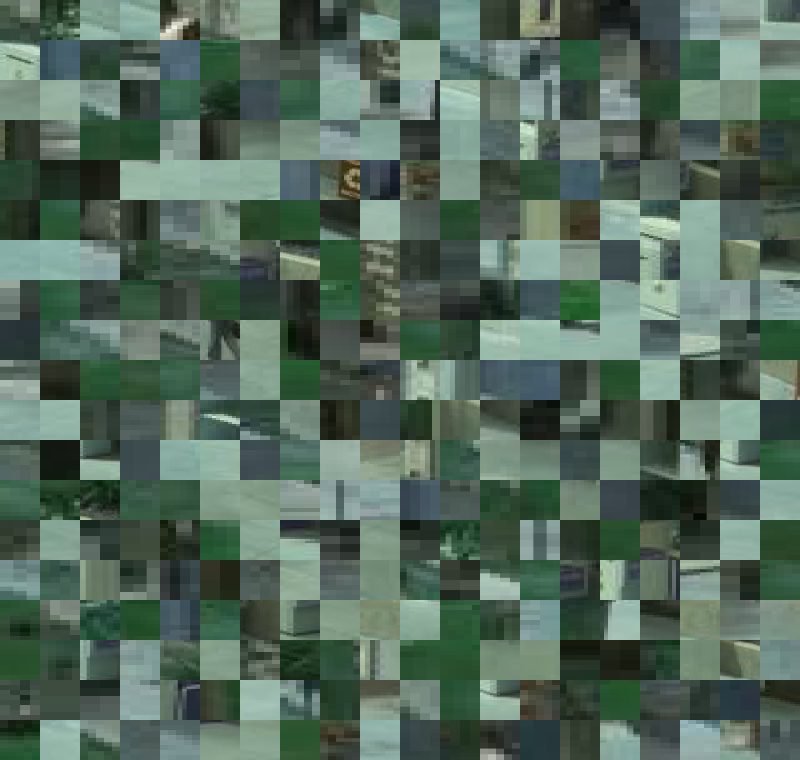

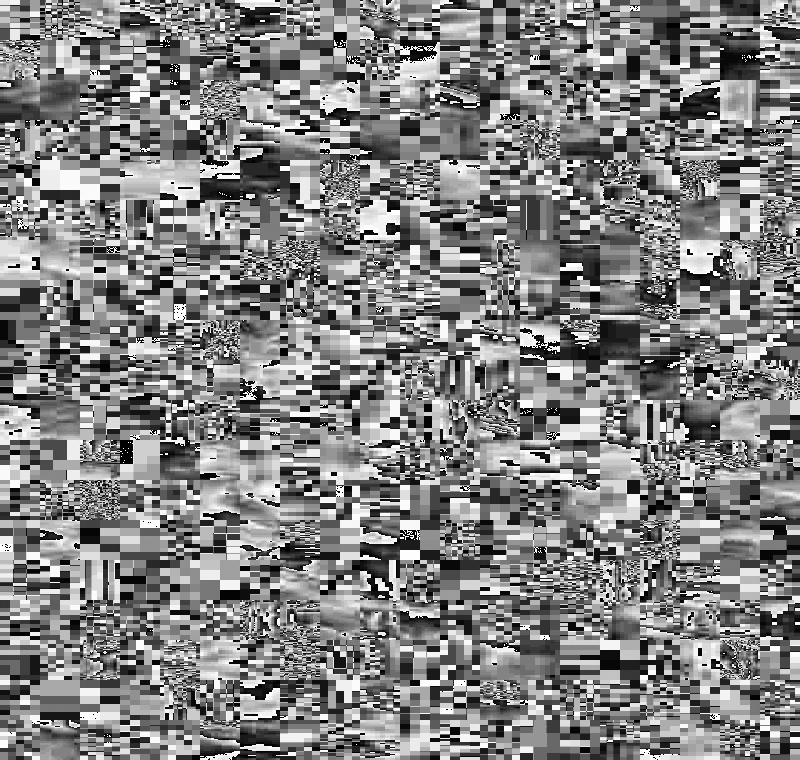

In [22]:

imageShow("Class1",0,Xtrain)
imageShow("Class test 1",0,[XFeaturesTrain[:400]])
imageShow("Class2",1,Xtrain)
imageShow("Class test 1",0,[XFeaturesTrain[400:800]])
imageShow("Class3",2,Xtrain)
imageShow("Class test 1",0,[XFeaturesTrain[800:1200]])
imageShow("Class4",3,Xtrain)
imageShow("Class test 1",0,[XFeaturesTrain[1200:1600]])

In [29]:

# numpy_vertical = np.vstack((image, grey_3_channel))
# numpy_horizontal = np.hstack((image, grey_3_channel))

A = np.array([np.reshape(XFeaturesTrain[i,:],(1,-1)) for i in range(XFeaturesTrain.shape[0])])
print(A.shape)
XFeaturesTrain =  np.squeeze(A)



# prepare test set
imgPath = '/content/faceAngle1/test/images'
posLabelPath = '/content/faceAngle1/train/labels'
imgList = os.listdir(imgPath)
posLabelList = os.listdir(posLabelPath)
mxTest=[]
myTest=[]
for i in range(len(imgList)):
    image = cv2.imread(imgPath+"/"+imgList[i])
    img = np.asarray(image)
    f = open(posLabelPath+"/"+posLabelList[i])
    lines = f.readlines()
    for line in lines:
        posLabel = np.array([np.float(i) for i in line.strip().split()])
        startX = int(image.shape[0]*(posLabel[2]-0.5*posLabel[-1]))
        startY = int(image.shape[1]*(posLabel[1]-0.5*posLabel[-2]))
        EndX = int(image.shape[0]*(posLabel[2]+0.5*posLabel[-1]))
        EndY = int(image.shape[1]*(posLabel[1]+0.5*posLabel[-2]))
        mxTest.append(chDim(img[startX:EndX, startY:EndY,::-1]))
        myTest.append(int(posLabel[0]))
    f.close

(1600, 1, 1600)


`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [30]:
poly = svm.SVC(kernel='poly', degree=5, C=1).fit(XFeaturesTrain, my)
 # evaluate accuracy
mxTest = np.array(mxTest)
myTest = np.array(myTest)


XFeaturesTest = listDataTransFeature(mxTest,LMc)


XFeaturesTest = np.squeeze(np.array([np.reshape(XFeaturesTest[i,:,:],(1,-1)) for i in range(XFeaturesTest.shape[0])]))

poly_pred = poly.predict(XFeaturesTest)

poly_accuracy = accuracy_score(myTest, poly_pred)
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))

Accuracy (Polynomial Kernel):  26.72
